In [40]:
import pandas as pd

# Load CSVs
trader_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')


In [44]:
# Convert datetime columns
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Extract date only
trader_df['date'] = trader_df['Timestamp'].dt.date
sentiment_df['date'] = sentiment_df['date'].dt.date


In [46]:
# Merge sentiment classification with trader data
merged_df = pd.merge(
    trader_df,
    sentiment_df[['date', 'classification']],
    on='date',
    how='inner'
)


In [60]:
print(trader_df[['Timestamp', 'Timestamp IST']].head())


            Timestamp     Timestamp IST
0 1970-01-01 00:28:50  02-12-2024 22:50
1 1970-01-01 00:28:50  02-12-2024 22:50
2 1970-01-01 00:28:50  02-12-2024 22:50
3 1970-01-01 00:28:50  02-12-2024 22:50
4 1970-01-01 00:28:50  02-12-2024 22:50


In [61]:
# Convert 'Timestamp IST' to datetime, specifying the format day-month-year hour:minute
trader_df['time'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Extract date only (without time)
trader_df['date'] = trader_df['time'].dt.date

# Check the result
print(trader_df[['Timestamp IST', 'time', 'date']].head())
print(f"Date range: {trader_df['date'].min()} to {trader_df['date'].max()}")


      Timestamp IST                time        date
0  02-12-2024 22:50 2024-12-02 22:50:00  2024-12-02
1  02-12-2024 22:50 2024-12-02 22:50:00  2024-12-02
2  02-12-2024 22:50 2024-12-02 22:50:00  2024-12-02
3  02-12-2024 22:50 2024-12-02 22:50:00  2024-12-02
4  02-12-2024 22:50 2024-12-02 22:50:00  2024-12-02
Date range: 2023-05-01 to 2025-05-01


In [62]:
merged_df = pd.merge(trader_df, sentiment_df[['date', 'classification']], on='date', how='inner')

print(f"Merged dataframe shape: {merged_df.shape}")
print(merged_df['classification'].value_counts())


Merged dataframe shape: (211218, 19)
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


In [63]:
results = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'count'],
    'Size USD': 'mean'
}).sort_index()

print(results)


               Closed PnL            Size USD
                     mean  count         mean
classification                               
Extreme Fear    34.537862  21400  5349.731843
Extreme Greed   67.892861  39992  3112.251565
Fear            54.290400  61837  7816.109931
Greed           42.743559  50303  5736.884375
Neutral         34.307718  37686  4782.732661


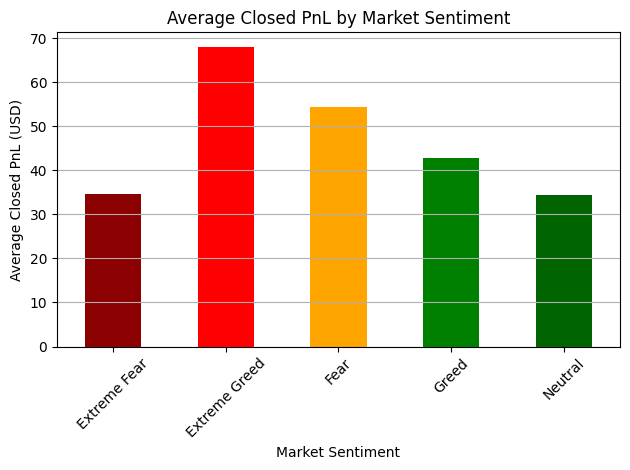

In [64]:
import matplotlib.pyplot as plt

results[('Closed PnL', 'mean')].plot(
    kind='bar',
    color=['darkred', 'red', 'orange', 'green', 'darkgreen'],  # colors for sentiment categories
    title='Average Closed PnL by Market Sentiment'
)
plt.ylabel('Average Closed PnL (USD)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


classification
Extreme Fear     37.060748
Extreme Greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: is_profit, dtype: float64


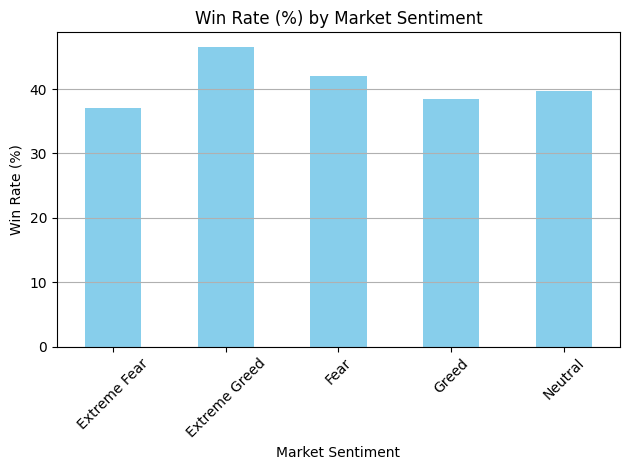

In [65]:
# Create a column for profitable trades
merged_df['is_profit'] = merged_df['Closed PnL'] > 0

# Calculate win rate by sentiment
win_rate = merged_df.groupby('classification')['is_profit'].mean() * 100

print(win_rate)

# Optional: Plot win rate
win_rate.plot(kind='bar', color='skyblue', title='Win Rate (%) by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Side                  BUY        SELL
classification                       
Extreme Fear    34.114627   34.980106
Extreme Greed   10.498927  114.584643
Fear            63.927104   45.049641
Greed           25.002302   59.691091
Neutral         29.227429   39.456408


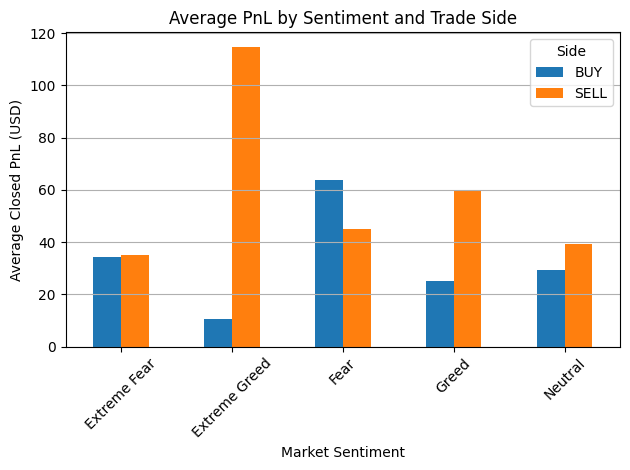

In [68]:
# Average PnL grouped by sentiment and side (long/short)
side_results = merged_df.groupby(['classification', 'Side'])['Closed PnL'].mean().unstack()

print(side_results)

# Optional: Plot
side_results.plot(kind='bar', title='Average PnL by Sentiment and Trade Side')
plt.ylabel('Average Closed PnL (USD)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
